In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import add
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score,precision_score,classification_report,roc_auc_score,roc_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('./data/fram_data.csv')

In [3]:
df.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


# EDA

- Part 1 - Understand the data
- Part 2 - Check the null model
- Part 3 - perform data cleanup
- Part 4 - Analyze the correlation with the Heatmap
- Part 5 - Analyze features in details

**EDA Part 1 - Understand the data**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [5]:
df.isnull().sum()

sex                  0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [6]:
df.shape

(4240, 16)

In [7]:
# check if there are duplicates
dup = df.duplicated()
print(dup.sum())

0


In [8]:
df.describe()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4240.000000,4240.000000,4135.000000,4240.000000,4211.000000,4187.000000,4240.000000,4240.000000,4240.000000,4190.000000,4240.000000,4240.000000,4221.000000,4239.000000,3852.000000,4240.000000
mean,0.429245,49.580189,1.979444,0.494104,9.005937,0.029615,0.005896,0.310613,0.025708,236.699523,132.354599,82.897759,25.800801,75.878981,81.963655,0.151887
std,0.495027,8.572942,1.019791,0.500024,11.922462,0.169544,0.076569,0.462799,0.158280,44.591284,22.033300,11.910394,4.079840,12.025348,23.954335,0.358953
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


**EDA Part 2 - Check the null model**

The target is 10 years heart disease and attribute at TenYearsCHD ("1" for "Yes", "0" for "No")

In [9]:
df['TenYearCHD'].value_counts(normalize = True)

0    0.848113
1    0.151887
Name: TenYearCHD, dtype: float64

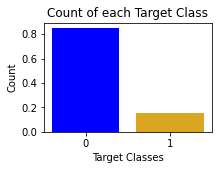

In [10]:
fig = plt.figure(figsize = (3,2))
plt.bar(df['TenYearCHD'].unique(), df['TenYearCHD'].value_counts(normalize = True), color = ['b', 'goldenrod'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Count of each Target Class');

In [11]:
print("The proportion of having CHD is {}% from total dataset ".format(round(df['TenYearCHD'].value_counts()[1]/len(df)*100,2)))

The proportion of having CHD is 15.19% from total dataset 


Based on the null model above, 15.19% patients have heart issue and 84.81% with no issue

**EDA Part 3 - Analyze the missing data and perform data cleanup**

- Remove education attribute since it doesn't impact the CHD
- Query missing data with graph
- Take care of 12.74% missing data and fill them with mean value cigsPerDay, BPMeds, totChol, BMI, heartRate, glucose)

In [12]:
df.drop(columns = ['education'], inplace = True)

In [13]:
missing_data = df.isnull().sum()
total_percentage = (missing_data.sum()/df.shape[0]) * 100
print(f'The total percentage of missing data is {round(total_percentage,2)}%')

The total percentage of missing data is 12.74%


In [14]:
# percentage of missing data per category
total = df.isnull().sum().sort_values(ascending=False)
percent_total = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
missing = pd.concat([total, percent_total], axis=1, keys=["Total", "Percentage"])
missing_data = missing[missing['Total']>0]
missing_data

,Total,Percentage
glucose,388,9.150943
BPMeds,53,1.250000
totChol,50,1.179245
cigsPerDay,29,0.683962
BMI,19,0.448113
heartRate,1,0.023585


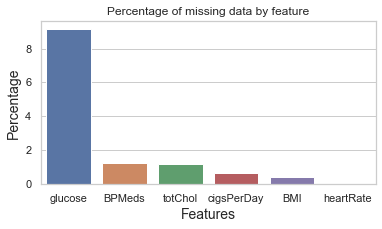

In [15]:
# visulize the missing data
plt.figure(figsize=(6,3))
sns.set(style="whitegrid")
sns.barplot(x=missing_data.index, y=missing_data['Percentage'], data = missing_data)
plt.title('Percentage of missing data by feature')
plt.xlabel('Features', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.show()

In [16]:
df['cigsPerDay'].fillna(value = df['cigsPerDay'].mean(), inplace = True)
df['BPMeds'].fillna(value = df['BPMeds'].mean(), inplace = True)
df['totChol'].fillna(value = df['totChol'].mean(), inplace = True)
df['BMI'].fillna(value = df['BMI'].mean(), inplace = True)
df['heartRate'].fillna(value = df['heartRate'].mean(), inplace = True)
df['glucose'].fillna(value = df['glucose'].mean(), inplace = True)

In [17]:
missing_data = df.isnull().sum()
total_percentage = (missing_data.sum()/df.shape[0]) * 100
print(f'The total percentage of missing data is {round(total_percentage,2)}%')

The total percentage of missing data is 0.0%


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   currentSmoker    4240 non-null   int64  
 3   cigsPerDay       4240 non-null   float64
 4   BPMeds           4240 non-null   float64
 5   prevalentStroke  4240 non-null   int64  
 6   prevalentHyp     4240 non-null   int64  
 7   diabetes         4240 non-null   int64  
 8   totChol          4240 non-null   float64
 9   sysBP            4240 non-null   float64
 10  diaBP            4240 non-null   float64
 11  BMI              4240 non-null   float64
 12  heartRate        4240 non-null   float64
 13  glucose          4240 non-null   float64
 14  TenYearCHD       4240 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 497.0 KB


**EDA Part 4 - Visualize the correlation with the Heatmap**

From the correlation at heatmap below, there are some multi-collinearity between features and they are highly co-related.  This can cause issues such as redundancy, less precise and reliable as well as overfitting for the model I am going to build.  For this reason, I need to reduce them by using PCA

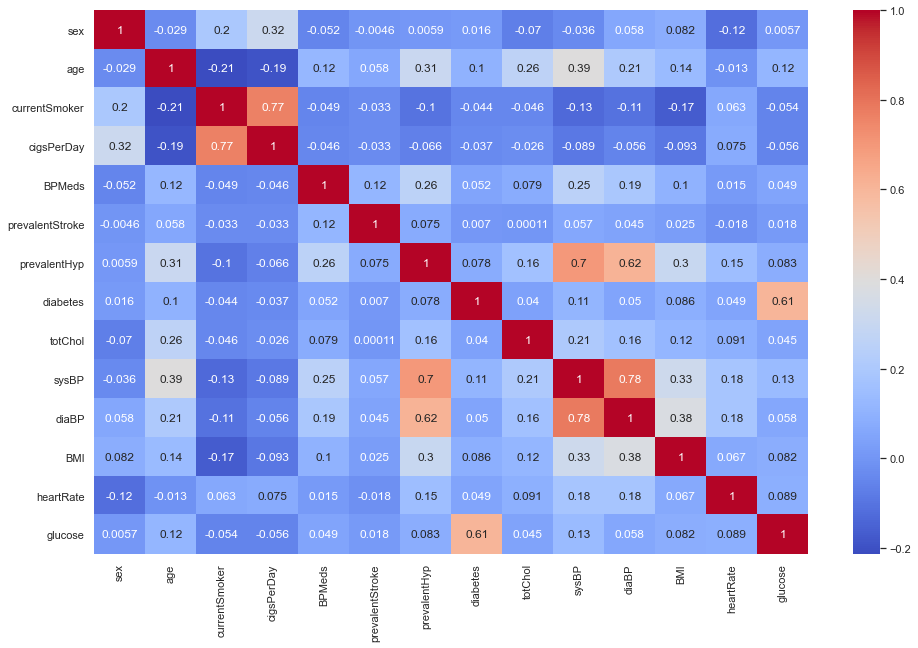

In [19]:
# view the heatmap
plt.figure(figsize = (16, 10))
df_features = df.drop(columns = 'TenYearCHD')
corr2 = df_features.corr()
sns.heatmap(corr2, annot = True, cmap = 'coolwarm');

Based on the Correlation Analysis, the following features are identified as Multi-Clollinearity below:
- The feature diabetes with glucose is 0.61 
- The feature prevalentHyp with sysBP and diaBP is at 0.7 and 0.62
- The feature currentSmoker with cigsPerDay is at 0.77

For futher understand the data, I will carry out the Feature Selection to pickup the features that are most impact to the target Ten Year CHD

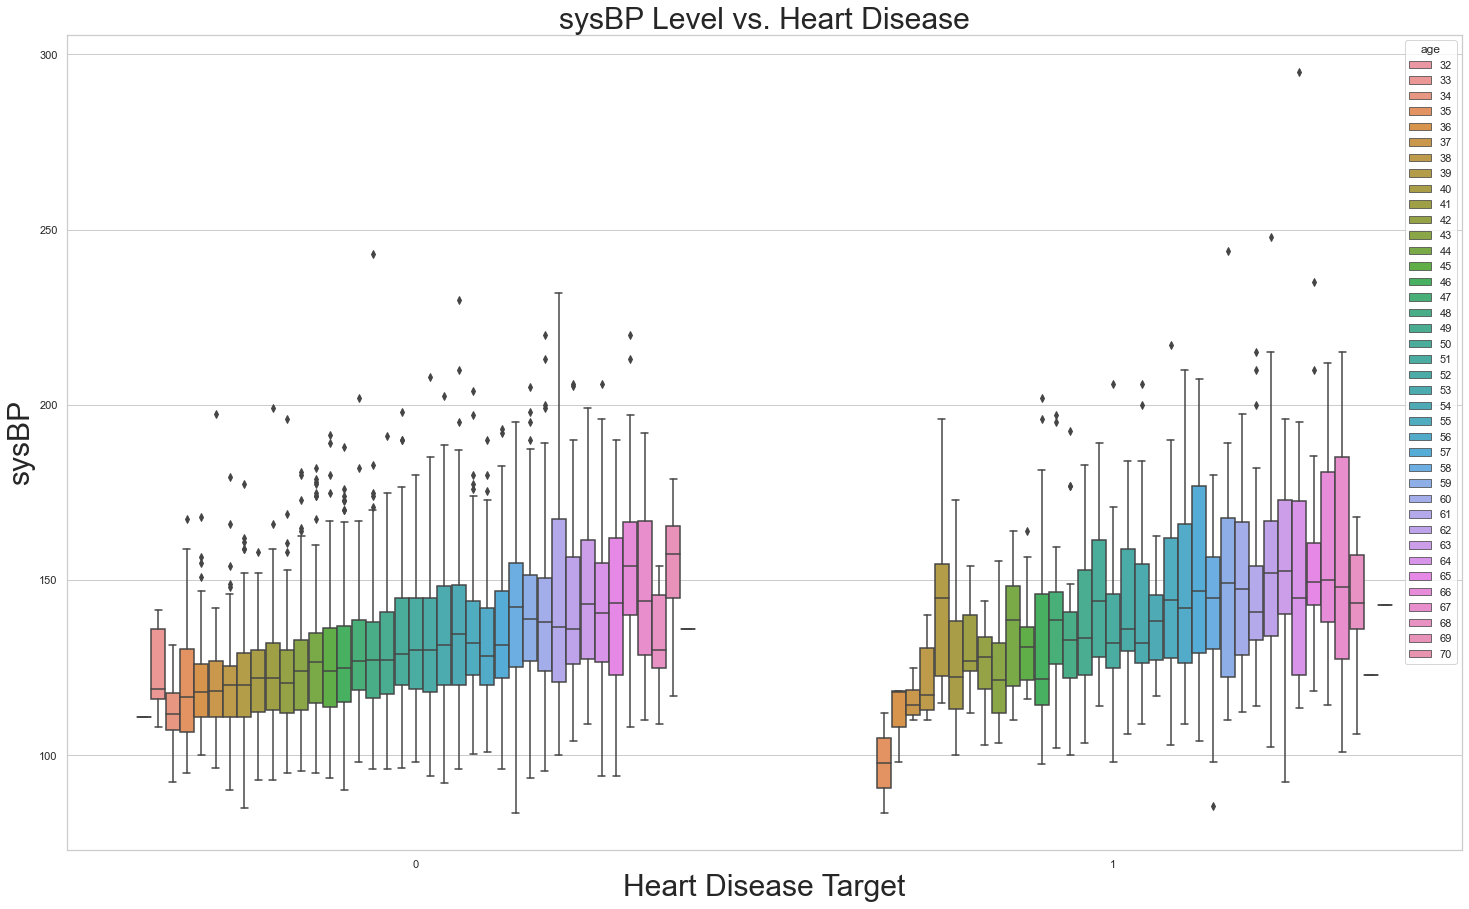

In [20]:
plt.figure(figsize=(25,15))

sns.boxplot(x= 'TenYearCHD', y='sysBP', hue='age', data=df )

plt.title('sysBP Level vs. Heart Disease', fontsize=30)

plt.xlabel('Heart Disease Target',fontsize=30)

plt.ylabel('sysBP', fontsize=30);

**EDA Part 5 - Analyze features in details**

Demographic: Sex, Age

Let us look at the distribution of the gender for each target class. We see that for females who are suffering from the disease are older than males.

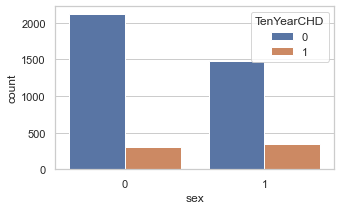

In [21]:
plt.figure(figsize = (5, 3))
sex_impact = sns.countplot(data = df, x = 'sex', hue = 'TenYearCHD')

People's age who are suffering from the disease or not:
- target = 1 implies that the person is suffering from heart disease
- target = 0 implies the person is not suffering

The graph shows that most people who are suffering are after the age of 50.  It clearly showed that people belonging to the age group 50+ are suffering from the disease.  

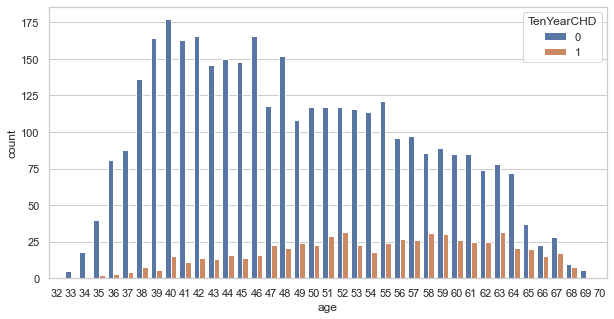

In [22]:
plt.figure(figsize = (10, 5))
#age_hist = sns.histplot(data=df, x='age', hue='TenYearCHD')
age_impact = sns.countplot(data = df, x = 'age', hue = 'TenYearCHD')

Identify the outliers:

Outliers can skew statistical measures and data distributions, providing a misleading representation of the underlying data and relationships. Removing outliers from training data prior to modeling can result in a better fit of the data and, in turn, more skillful predictions.

It would be invalid to fit the outlier detection method on the entire training dataset as this would result in data leakage. That is, the model would have access to data (or information about the data) in the test set not used to train the model. This may result in an optimistic estimate of model performance.

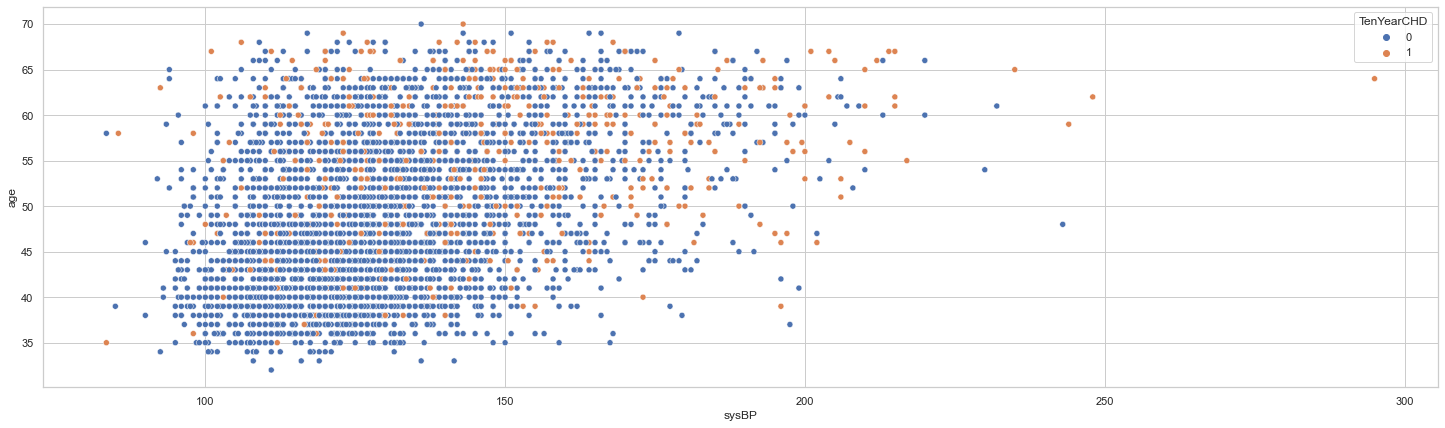

In [23]:
plt.figure(figsize = (25, 7))
sns.scatterplot(data=df, x="sysBP", y="age", hue="TenYearCHD");

Based on the graph above, there are outline and I need to check it in details



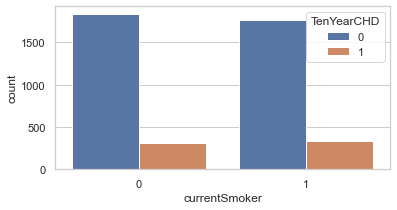

In [24]:
plt.figure(figsize = (6, 3))
sex_impact = sns.countplot(data = df, x = 'currentSmoker', hue = 'TenYearCHD')

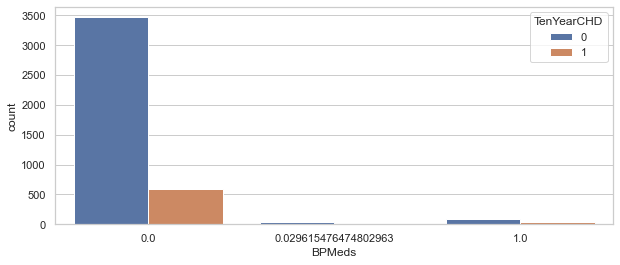

In [25]:
plt.figure(figsize = (10, 4))
sex_impact = sns.countplot(data = df, x = 'BPMeds', hue = 'TenYearCHD')

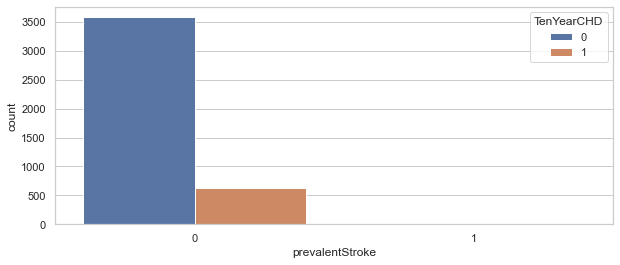

In [26]:
plt.figure(figsize = (10, 4))
sex_impact = sns.countplot(data = df, x = 'prevalentStroke', hue = 'TenYearCHD')

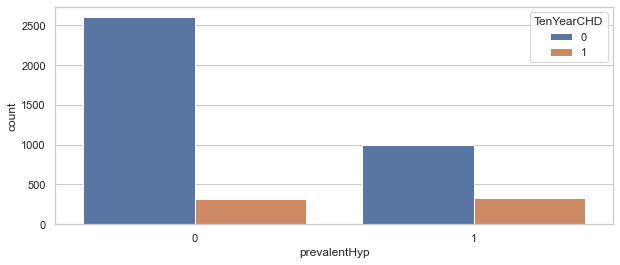

In [27]:
plt.figure(figsize = (10, 4))
sex_impact = sns.countplot(data = df, x = 'prevalentHyp', hue = 'TenYearCHD')

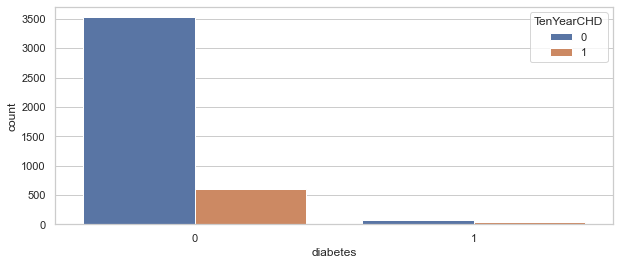

In [28]:
plt.figure(figsize = (10, 4))
sex_impact = sns.countplot(data = df, x = 'diabetes', hue = 'TenYearCHD')

**Analyze distribution by histogram**

The histogram shows how each feature and label is distributed along different ranges, which further confirms the need for scaling. 

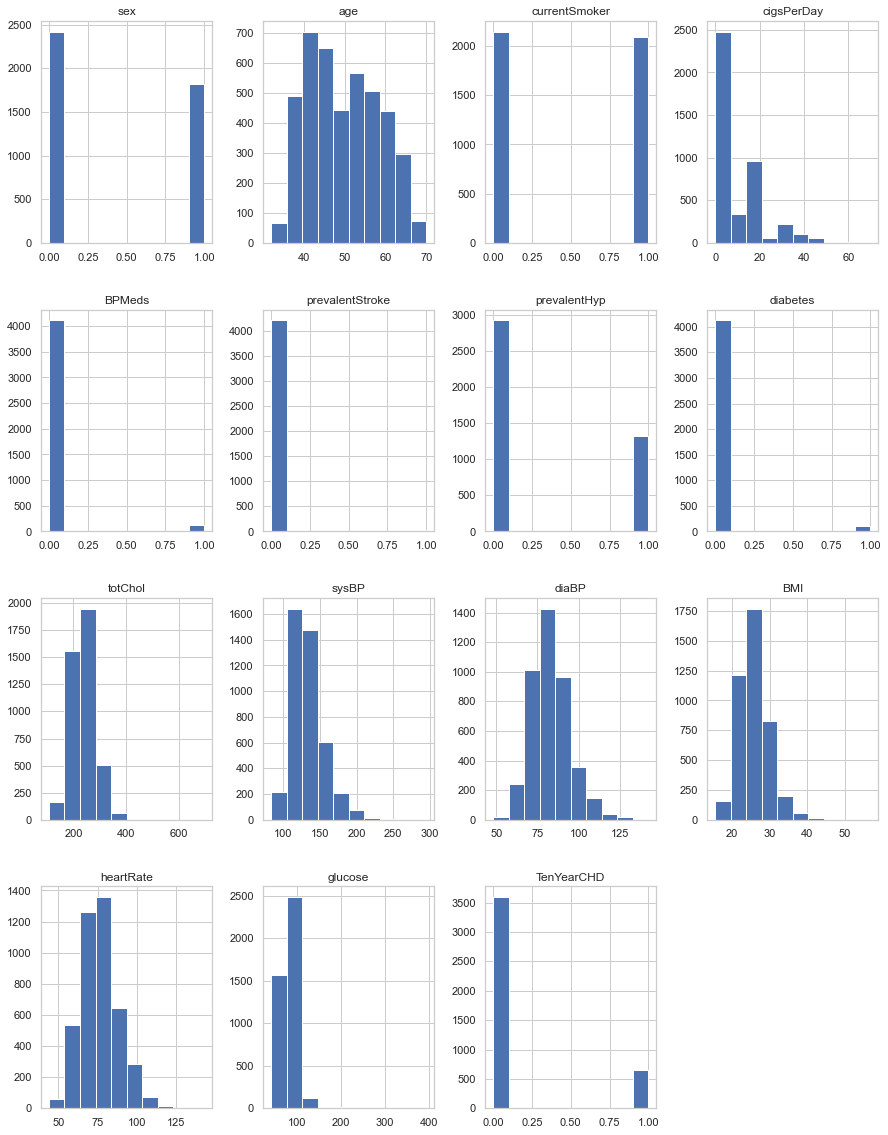

In [29]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax)
plt.show();

**Perform Feature Engineer to convert category data by get_dummies**

Wherever there are discrete bars, it basically means that each of these is actually a categorical variable such as male, currentSmoker, BPMeds, PrevalentStoke, PrevalentHyp, Diabetes

I need to handle these categorical variables before applying Machine Learning. Our target labels have two classes, 0 for no disease and 1 for disease.

In [30]:
df.head()

,sex,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [31]:
df_dummy = pd.get_dummies(df, columns = ['prevalentStroke'], drop_first = True)

In [32]:
df_dummy.head()

,sex,age,currentSmoker,cigsPerDay,BPMeds,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,prevalentStroke_1
0,1,39,0,0.0,0.0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,0
1,0,46,0,0.0,0.0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,0
2,1,48,1,20.0,0.0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,0
3,0,61,1,30.0,0.0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1,0
4,0,46,1,23.0,0.0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,0


In [33]:
def stacked_barchart(data, title = None, ylabel = None, xlabel = None):
    default_colors = ['b', 'goldenrod', '#219AD8']
    # From raw value to percentage
    totals = data.sum(axis=1)
    bars = ((data.T / totals) * 100).T
    r = list(range(data.index.size))

    # Plot
    barWidth = 0.95
    names = data.index.tolist()
    bottom = [0] * bars.shape[0]

    # Create bars
    color_index = 0
    plots = []
    for bar in bars.columns:
        plots.append(plt.bar(r, bars[bar], bottom=bottom, color=default_colors[color_index], edgecolor='white', width=barWidth))
        bottom = list(map(add, bottom, bars[bar]))
        color_index = 0 if color_index >= len(default_colors) else color_index + 1

    # Custom x axis
    plt.title(title)
    plt.xticks(r, names)
    plt.xlabel(data.index.name if xlabel is None else xlabel)
    plt.ylabel(data.columns.name if ylabel is None else ylabel)
    ax = plt.gca()
        
    y_labels = ax.get_yticks()
    ax.set_yticklabels([str(y) + '%' for y in y_labels])

    flat_list = [item for sublist in data.T.values for item in sublist]
    for i, d in zip(ax.patches, flat_list):
        data_label = str(d) + " (" + str(round(i.get_height(), 2)) + "%)"
        ax.text(i.get_x() + 0.45, i.get_y() + 5, data_label, horizontalalignment='center', verticalalignment='center', fontdict = dict(color = 'white', size = 20))

    for item in ([ax.title]):
        item.set_fontsize(27)
        
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)
    
    legend = ax.legend(plots, bars.columns.tolist(), fancybox=True)
    plt.setp(legend.get_texts(), fontsize='20')

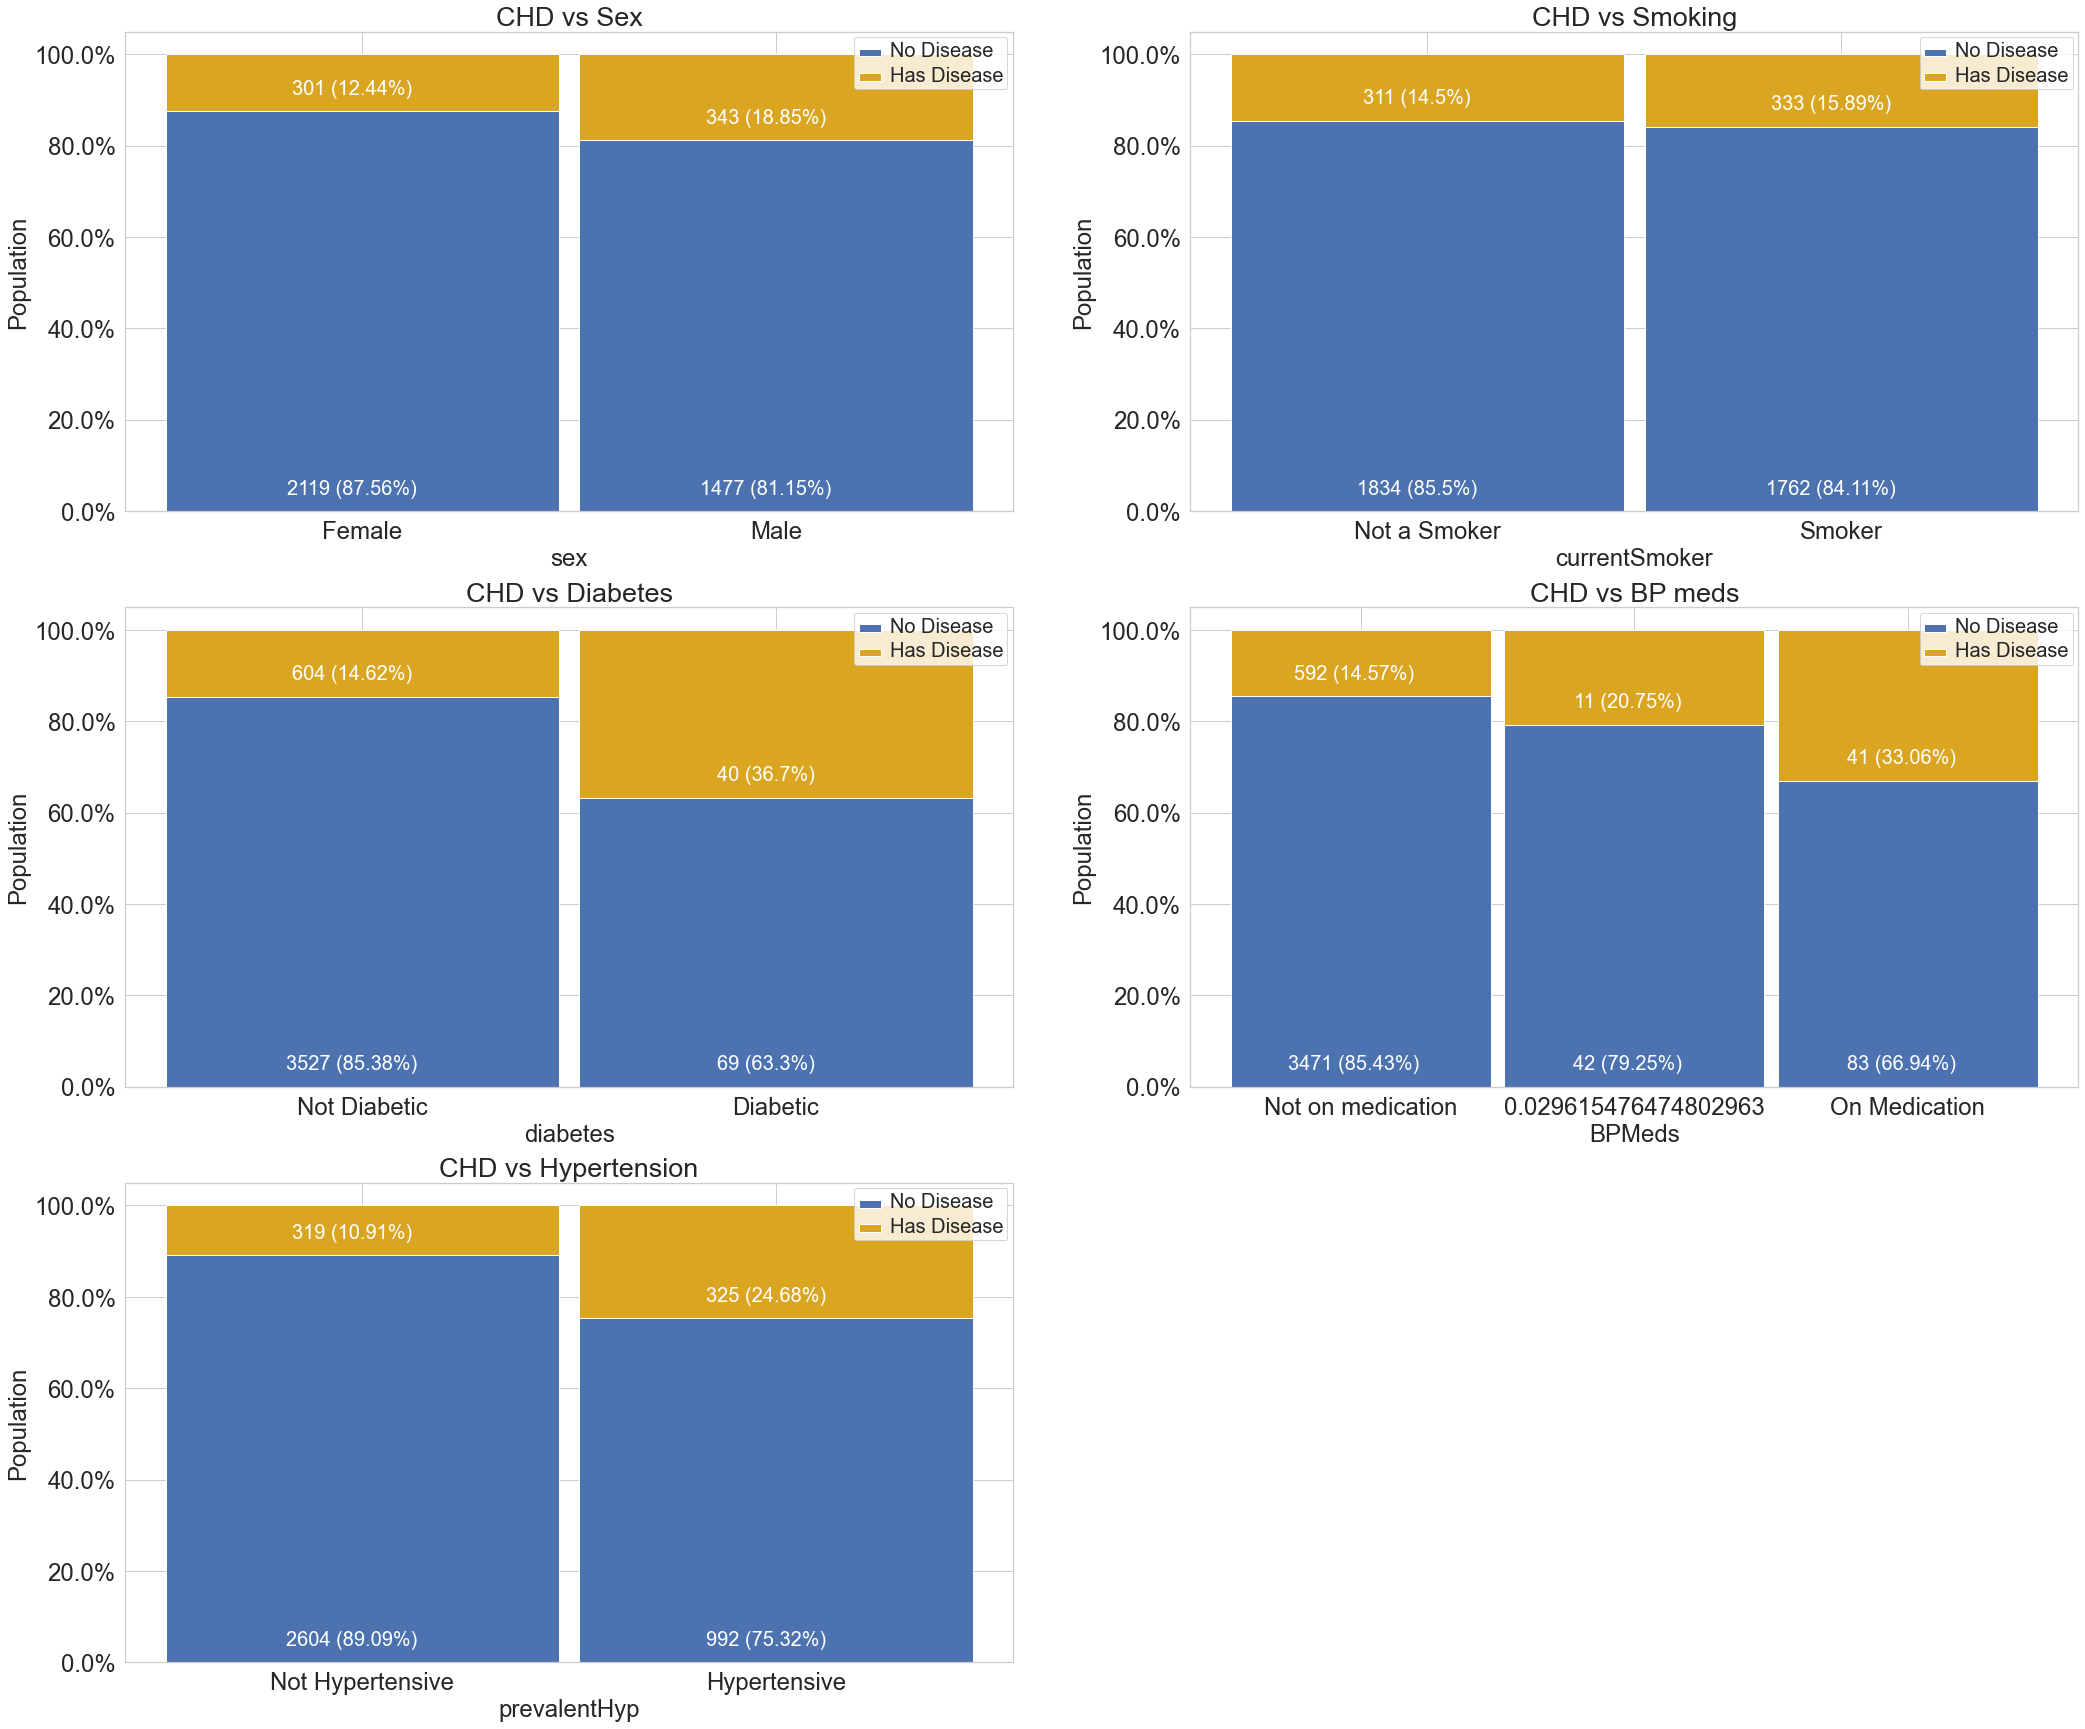

In [34]:
fig = plt.gcf()
fig.set_size_inches(35, 30)
grid_rows = 3
grid_cols = 2

#draw sex vs disease outcome
plt.subplot(grid_rows, grid_cols, 1)
temp = df[['sex','TenYearCHD']].groupby(['sex','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Female', 1:'Male'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Sex', ylabel = 'Population')

#draw smoking satus vs disease outcome
plt.subplot(grid_rows, grid_cols, 2)
temp = df[['currentSmoker','TenYearCHD']].groupby(['currentSmoker','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not a Smoker', 1:'Smoker'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Smoking', ylabel = 'Population')

#draw diabetes vs disease outcome
plt.subplot(grid_rows, grid_cols, 3)
temp = df[['diabetes','TenYearCHD']].groupby(['diabetes','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not Diabetic', 1:'Diabetic'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Diabetes', ylabel = 'Population')

#draw BP meds vs disease outcome
plt.subplot(grid_rows, grid_cols, 4)
temp = df[['BPMeds','TenYearCHD']].groupby(['BPMeds','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not on medication', 1:'On Medication'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs BP meds', ylabel = 'Population')

#draw Hypertension vs disease outcome
plt.subplot(grid_rows, grid_cols, 5)
temp = df[['prevalentHyp','TenYearCHD']].groupby(['prevalentHyp','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not Hypertensive', 1:'Hypertensive'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Hypertension', ylabel = 'Population')

# Data preprocessing

**Features Selection**

The feature importance describes which features are relevant. It can help with better understanding of the solved problem and sometimes lead to model improvements by employing the feature selection.

I use the Gini importance (or mean decrease impurity) method, which is computed from the Random Forest structure to get my top features that impact the heart disease the most.

In [35]:
# setup X and y
X = df.drop('TenYearCHD', axis = 1)
y = df['TenYearCHD']

In [36]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

In [37]:
# initiate Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [38]:
# get feature_importance
rfc.feature_importances_
X_train.columns

Index(['sex', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose'],
      dtype='object')

In [39]:
features=np.array(X_train.columns)
important=rfc.feature_importances_

In [40]:
indexes_features=important.argsort()
for i in indexes_features:
    print("{} : {:.2f}%".format(features[i],important[i]*100))

prevalentStroke : 0.38%
diabetes : 0.60%
BPMeds : 1.10%
currentSmoker : 1.49%
prevalentHyp : 1.81%
sex : 2.42%
cigsPerDay : 6.33%
heartRate : 10.03%
diaBP : 12.24%
glucose : 12.29%
BMI : 12.42%
totChol : 12.60%
age : 12.65%
sysBP : 13.64%


Text(0.5, 1.0, 'Feature Importance')

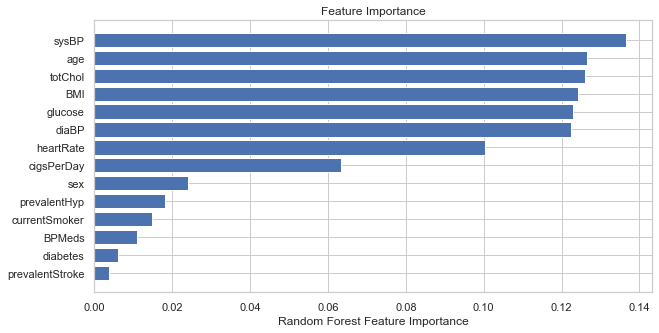

In [41]:
plt.figure(figsize = (10, 5))
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(features[sorted_idx], important[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("Feature Importance")

Based on the Feature Important analysis above, the top 8 features that are greatly impacted the heart disease are listed below by order:

- sysBP (Systolic Blood Pressure) is 13.64%
- age is 12.65%
- totChol (Total Cholesterol) is 12.60%
- BMI is 12.42%
- glucose is 12.29%
- diaBP (Diastolic Blood Pressure) is 12.24%
- heartRate (Heart Rate) is 10.03%
- cigsPerDay (Cigar Per Day) is 6.33%

In [42]:
X_top = df[['sysBP', 'age', 'totChol', 'BMI', 'glucose', 'diaBP', 'heartRate', 'cigsPerDay']]

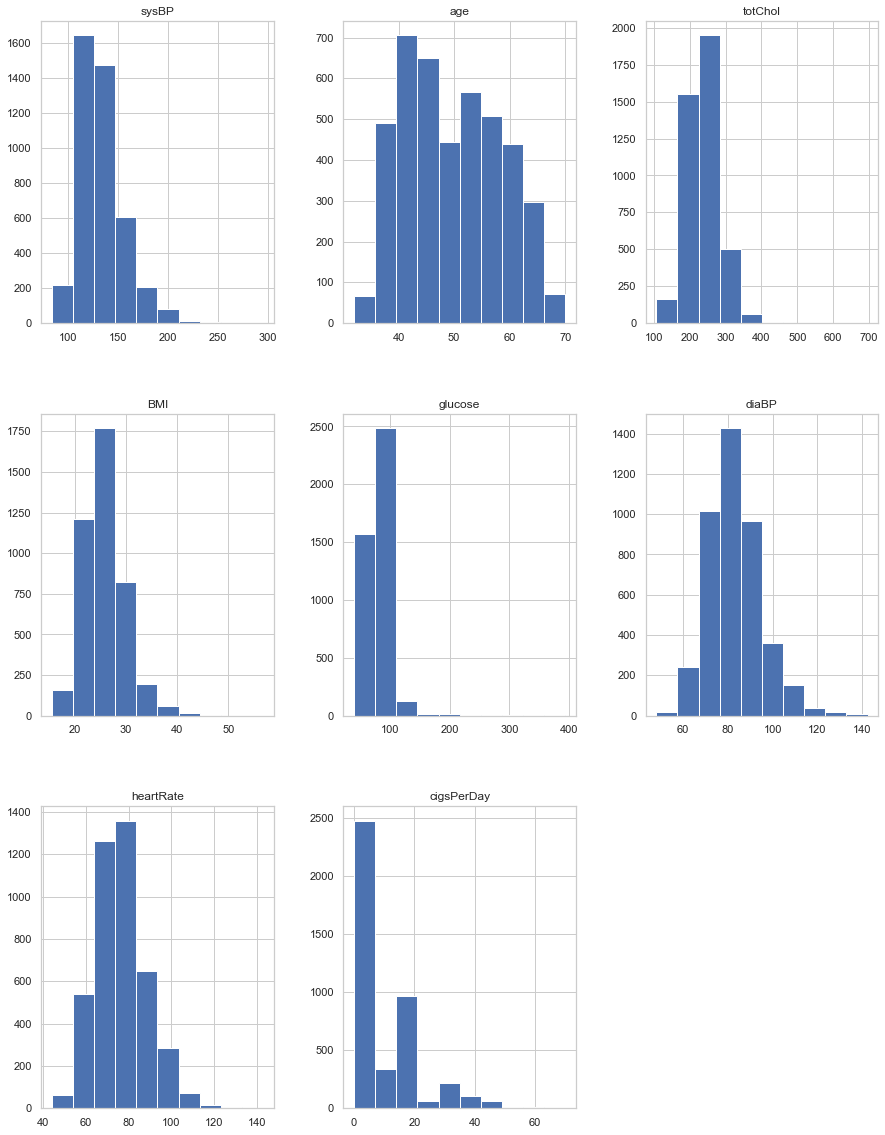

In [43]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
X_top.hist(ax = ax)
plt.show();

# Statistics on the top features

In [44]:
# Apply logit function
res = sm.Logit(y,X_top).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.413683
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4240
Model:                          Logit   Df Residuals:                     4232
Method:                           MLE   Df Model:                            7
Date:                Mon, 14 Jun 2021   Pseudo R-squ.:                 0.02884
Time:                        17:38:10   Log-Likelihood:                -1754.0
converged:                       True   LL-Null:                       -1806.1
Covariance Type:            nonrobust   LLR p-value:                 1.477e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sysBP          0.0251      0.003      7.991      0.000       0.019       0.031
age            0.0248      0.005      4.640      0.000       0.014       0.035
totChol       -0.0035      0.001     -3.365      0.001      -0.005      -0.001
BMI           -0.0536      0.011     -4.749      0.000      -0.076      -0.031
glucose        0.0038      0.002      2.356      0.018       0.001       0.007
diaBP         -0.0273      0.006     -4.924      0.000      -0.038      -0.016
heartRate     -0.0308      0.004     -8.658      0.000      -0.038      -0.024
cigsPerDay     0.0167      0.004      4.721      0.000       0.010       0.024
==============================================================================
"""

In [45]:
params = res.params
conf = res.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                  5%       95%  Odds Ratio
sysBP       1.019097  1.031704    1.025381
age         1.014447  1.035958    1.025146
totChol     0.994541  0.998556    0.996547
BMI         0.927057  0.969001    0.947797
glucose     1.000645  1.007046    1.003840
diaBP       0.962521  0.983686    0.973046
heartRate   0.962972  0.976479    0.969702
cigsPerDay  1.009819  1.023924    1.016847


Based on the logit function output, I observed that holding all other features constant, the odds of getting diagnosed with heart disease increases with about 2% for every increase in age an systolic blood pressure.  The other factors show no significant positive odds

In [46]:
df_top = pd.concat([X_top, y], axis = 1)

In [47]:
df_top

,sysBP,age,totChol,BMI,glucose,diaBP,heartRate,cigsPerDay,TenYearCHD
0,106.0,39,195.0,26.97,77.000000,70.0,80.0,0.0,0
1,121.0,46,250.0,28.73,76.000000,81.0,95.0,0.0,0
2,127.5,48,245.0,25.34,70.000000,80.0,75.0,20.0,0
3,150.0,61,225.0,28.58,103.000000,95.0,65.0,30.0,1
4,130.0,46,285.0,23.10,85.000000,84.0,85.0,23.0,0
...,...,...,...,...,...,...,...,...,...
4235,131.0,48,248.0,22.00,86.000000,72.0,84.0,20.0,0
4236,126.5,44,210.0,19.16,81.963655,87.0,86.0,15.0,0
4237,133.5,52,269.0,21.47,107.000000,83.0,80.0,0.0,0
4238,141.0,40,185.0,25.60,72.000000,98.0,67.0,0.0,0


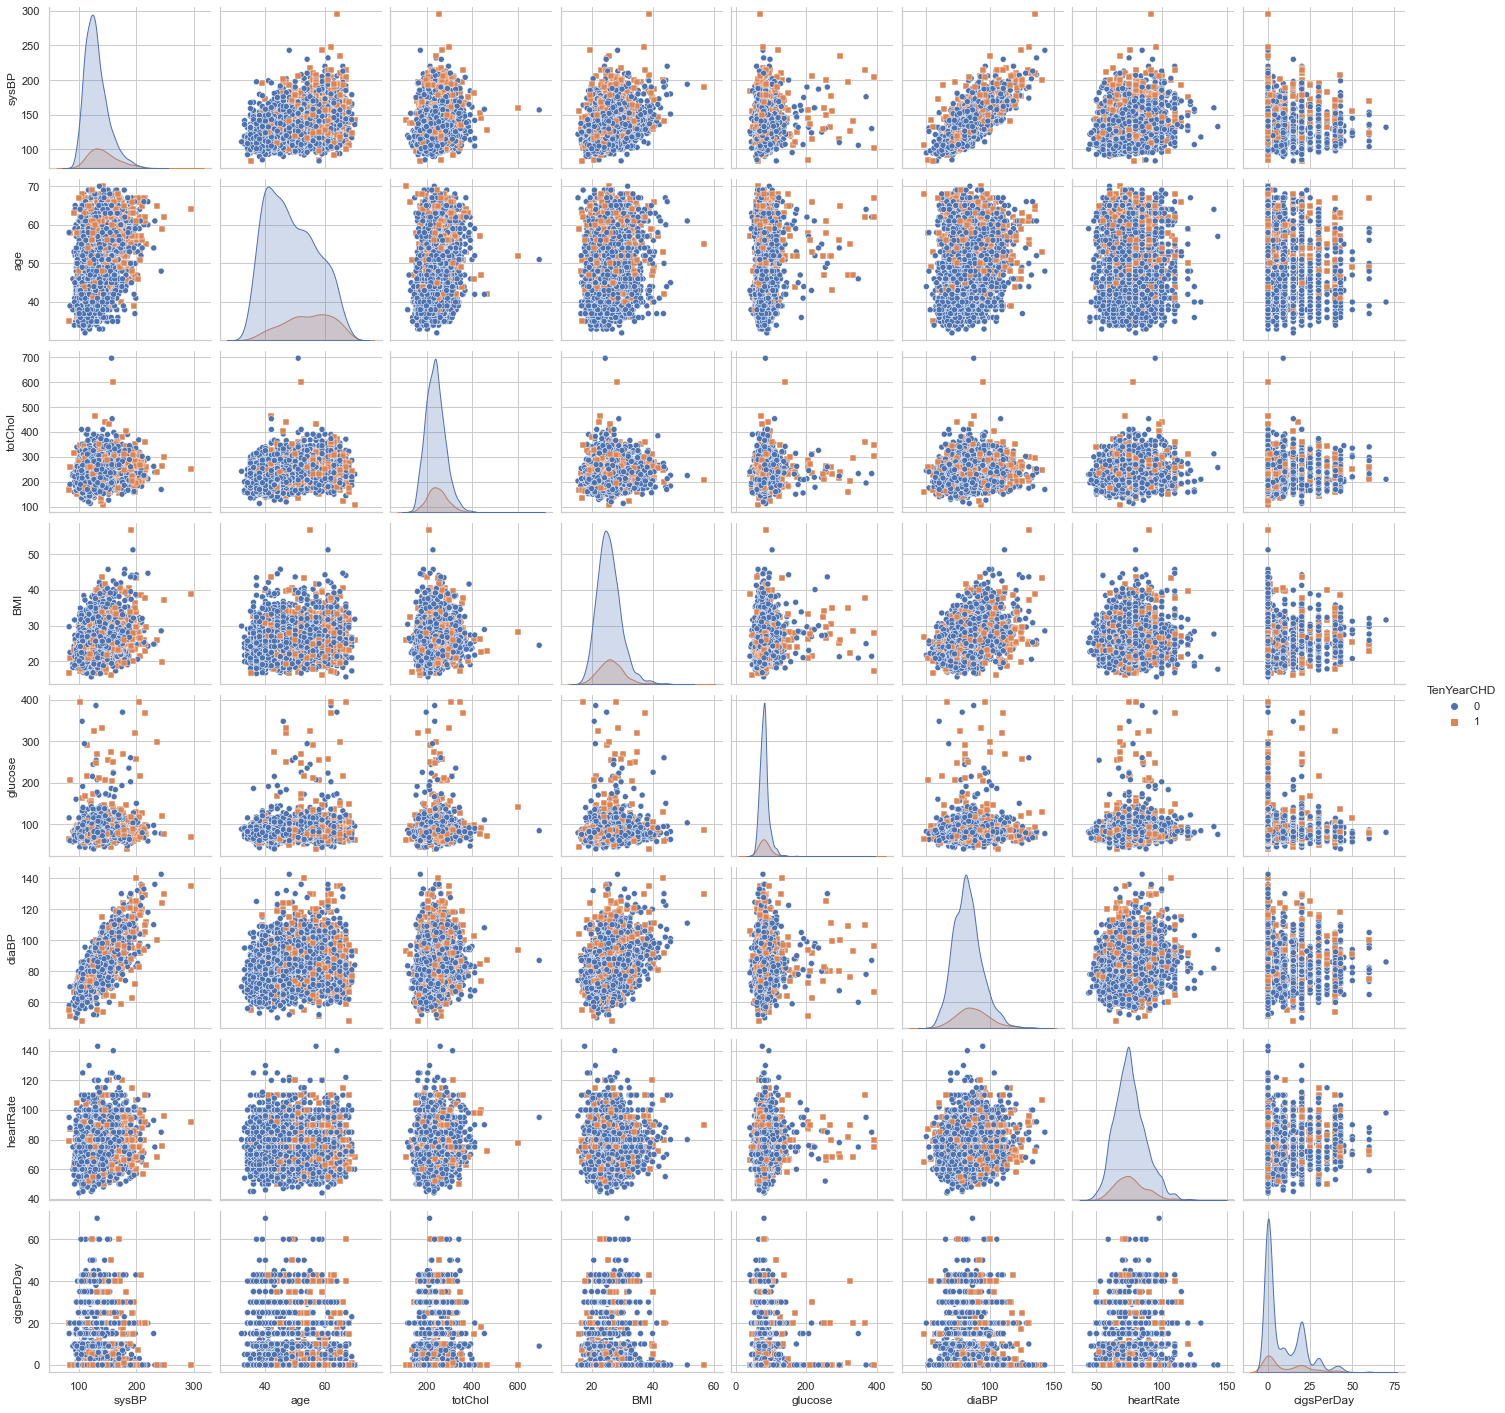

In [48]:
#sns.pairplot(df_top, hue = 'TenYearCHD', markers=["o", "s"], vars = X_top, palette = sns.color_palette("bright", 10))
sns.pairplot(df_top, hue = 'TenYearCHD', vars = X_top, markers=["o", "s"]) #, palette = sns.color_palette("bright", 10))

# Class Balance by SMOTE

**Take care of inballanced class by using SMOTE**

In [49]:
df_top.head()

,sysBP,age,totChol,BMI,glucose,diaBP,heartRate,cigsPerDay,TenYearCHD
0,106.0,39,195.0,26.97,77.0,70.0,80.0,0.0,0
1,121.0,46,250.0,28.73,76.0,81.0,95.0,0.0,0
2,127.5,48,245.0,25.34,70.0,80.0,75.0,20.0,0
3,150.0,61,225.0,28.58,103.0,95.0,65.0,30.0,1
4,130.0,46,285.0,23.10,85.0,84.0,85.0,23.0,0


In [50]:
X_top = df_top.drop(columns = 'TenYearCHD')
y_top = df_top['TenYearCHD']

In [51]:
# the numbers before SMOTE
num_before = dict(Counter(y))

#perform SMOTE

# define pipeline
over = SMOTE(sampling_strategy=0.8)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_smote, y_smote = pipeline.fit_resample(X_top, y_top)


#the numbers after SMOTE
num_after =dict(Counter(y_smote))

In [52]:
print(num_before, num_after)

{0: 3596, 1: 644} {0: 3595, 1: 2876}


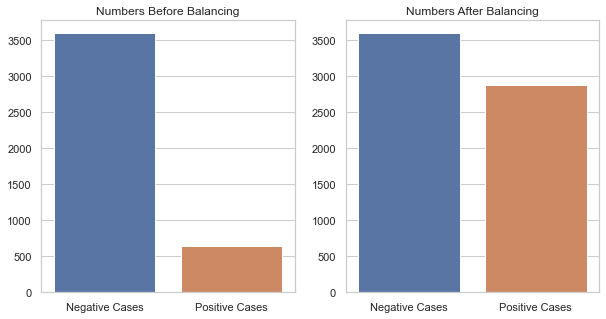

In [53]:
labels = ["Negative Cases","Positive Cases"]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.barplot(labels, list(num_before.values()))
plt.title("Numbers Before Balancing")
plt.subplot(1,2,2)
sns.barplot(labels, list(num_after.values()))
plt.title("Numbers After Balancing")
plt.show()

It’s really essential that the dataset we are working on should be approximately balanced. An extremely imbalanced dataset can render the whole model training useless and thus, will be of no use. Let’s understand it with an example.

Based on the Bar Graph below, we can see that the classes are almost inbalanced. The class for 1 is 15% and the class for 0 is 85%. 

After applying SMOTE, the new dataset is much more balanced: the new ratio between negative and positive cases is 1:1.2 up from 1:5.57

Splitting data to Training and Testing set

In [54]:
# new dataset
new_data = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(y_smote)], axis=1)
new_data.head()

,sysBP,age,totChol,BMI,glucose,diaBP,heartRate,cigsPerDay,TenYearCHD
0,105.0,44,163.000000,21.02,62.000000,72.5,67.0,20.000000,0
1,185.0,61,236.699523,35.22,81.963655,121.0,80.0,0.000000,0
2,120.0,49,280.000000,22.33,75.000000,80.0,90.0,9.005937,0
3,134.0,55,273.000000,32.17,67.000000,92.0,75.0,0.000000,0
4,108.0,46,165.000000,24.19,72.000000,81.0,80.0,0.000000,0


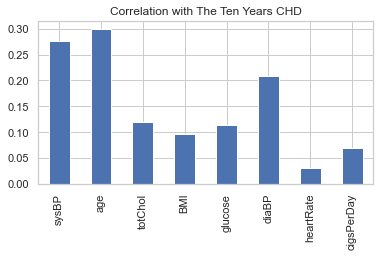

In [55]:
new_data.drop('TenYearCHD', axis=1).corrwith(new_data.TenYearCHD).plot(kind='bar', grid=True, figsize=(6, 3), title="Correlation with The Ten Years CHD");

# Feature Scaling

Feature scaling is a method used to normalize the range of independent variables or features of data. It generally speeds up the running time of different algorithms

In [56]:
# Setup X_new and y_new
X_new = new_data.drop(columns = 'TenYearCHD')
y_new = new_data['TenYearCHD']

In [57]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = .2, random_state = 42)

In [58]:
# Scaling Data
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)

X_test_sc = sc.transform(X_test)
X_test = pd.DataFrame(X_test_sc)

# Modeling

The four algorithms that will be used are:

- Logistic Regression
- k-Nearest Neighbours
- Decision Trees
- Support Vector Machine

**Logistics Regression**

In [59]:
# search for optimun parameters using gridsearch
params = {'penalty':['l1','l2'],
         'C':[0.01,0.1,1,10,100],
         'class_weight':['balanced',None]}
logistic_clf = GridSearchCV(LogisticRegression(),param_grid=params,cv=10, scoring = 'recall')

In [60]:
#train the classifier
logistic_clf.fit(X_train, y_train)

logistic_clf.best_params_

{'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}

In [61]:
#make predictions
logistic_predict = logistic_clf.predict(X_test)

In [62]:
log_accuracy = accuracy_score(y_test,logistic_predict)
print(f"Using logistic regression we get an accuracy of {round(log_accuracy*100,2)}%")

Using logistic regression we get an accuracy of 66.02%


<AxesSubplot:>

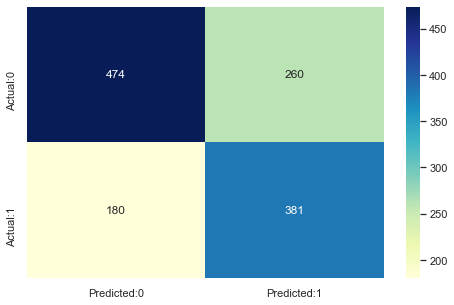

In [63]:
cm=confusion_matrix(y_test,logistic_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [64]:
print(classification_report(y_test,logistic_predict))

              precision    recall  f1-score   support

           0       0.72      0.65      0.68       734
           1       0.59      0.68      0.63       561

    accuracy                           0.66      1295
   macro avg       0.66      0.66      0.66      1295
weighted avg       0.67      0.66      0.66      1295



In [65]:
logistic_f1 = f1_score(y_test, logistic_predict)
print(f'The f1 score for logistic regression is {round(logistic_f1*100,2)}%')

The f1 score for logistic regression is 63.39%


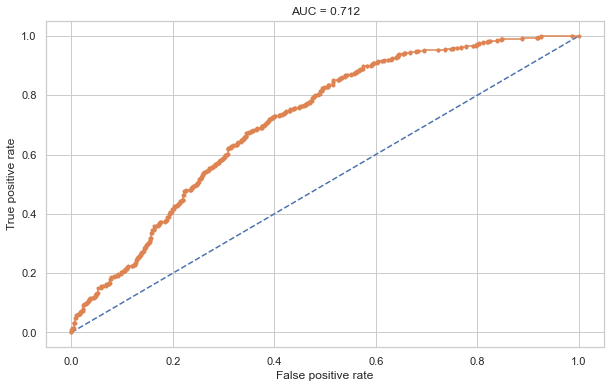

In [66]:
# ROC curve and AUC 
probs = logistic_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

k-Nearest Neighbours

In [67]:
# search for optimun parameters using gridsearch
params= {'n_neighbors': np.arange(1, 10)}
grid_search = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = params, 
                           scoring = 'accuracy', cv = 10, n_jobs = -1)
knn_clf = GridSearchCV(KNeighborsClassifier(),params,cv=3, n_jobs=-1, scoring = 'recall')

In [68]:
# train the model
knn_clf.fit(X_train,y_train)
knn_clf.best_params_ 

{'n_neighbors': 1}

In [69]:
# predictions
knn_predict = knn_clf.predict(X_test)

In [70]:
#accuracy
knn_accuracy = accuracy_score(y_test,knn_predict)
print(f"Using k-nearest neighbours we get an accuracy of {round(knn_accuracy*100,2)}%")

Using k-nearest neighbours we get an accuracy of 84.48%


<AxesSubplot:>

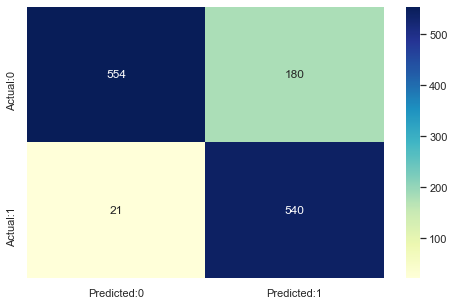

In [71]:
cm=confusion_matrix(y_test,knn_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [72]:
print(classification_report(y_test,knn_predict))

              precision    recall  f1-score   support

           0       0.96      0.75      0.85       734
           1       0.75      0.96      0.84       561

    accuracy                           0.84      1295
   macro avg       0.86      0.86      0.84      1295
weighted avg       0.87      0.84      0.84      1295



In [73]:
knn_f1 = f1_score(y_test, knn_predict)
print(f'The f1 score for K nearest neignbours is {round(knn_f1*100,2)}%')

The f1 score for K nearest neignbours is 84.31%


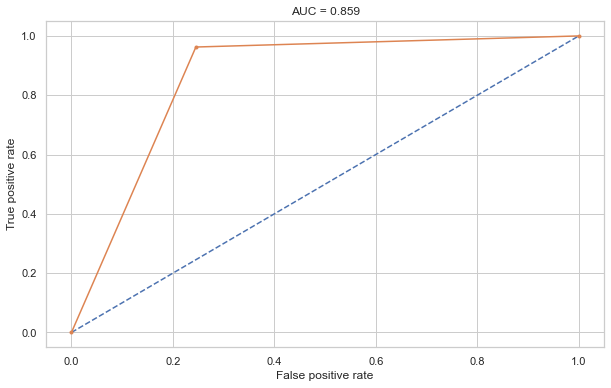

In [74]:
# ROC curve and AUC 
probs = knn_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
knn_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(knn_auc,3)}")
plt.show()

**Decision Trees**

In [75]:
# grid search for optimum parameters
dtree= DecisionTreeClassifier(random_state=7)
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11]}
tree_clf = GridSearchCV(dtree, param_grid=params, n_jobs=-1, scoring = 'recall')

In [76]:
# train the model
tree_clf.fit(X_train,y_train)
tree_clf.best_params_ 

{'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}

In [77]:
# predictions
tree_predict = tree_clf.predict(X_test)

In [78]:
#accuracy
tree_accuracy = accuracy_score(y_test,tree_predict)
print(f"Using Decision Trees we get an accuracy of {round(tree_accuracy*100,2)}%")

Using Decision Trees we get an accuracy of 75.75%


<AxesSubplot:>

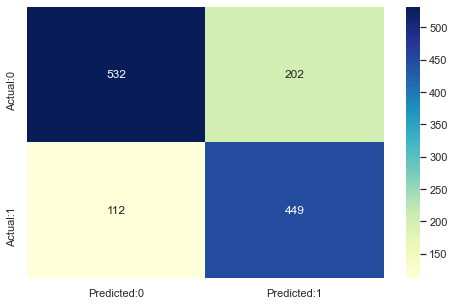

In [79]:
cm=confusion_matrix(y_test,tree_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [80]:
print(classification_report(y_test,tree_predict))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       734
           1       0.69      0.80      0.74       561

    accuracy                           0.76      1295
   macro avg       0.76      0.76      0.76      1295
weighted avg       0.77      0.76      0.76      1295



In [81]:
tree_f1 = f1_score(y_test, tree_predict)
print(f'The f1 score Descision trees is {round(tree_f1*100,2)}%')

The f1 score Descision trees is 74.09%


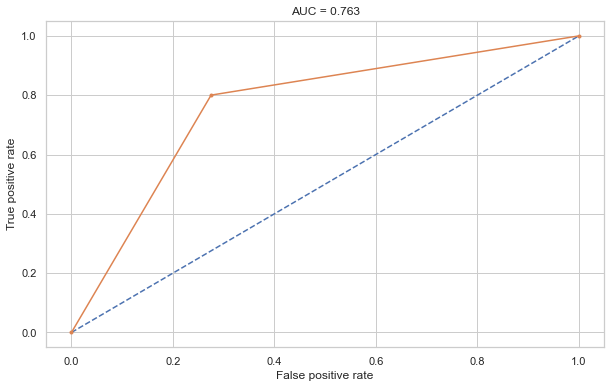

In [82]:
# ROC curve and AUC 
probs = tree_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
tree_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(tree_auc,3)}")
plt.show()

**Support Vector Machine**

In [83]:
#grid search for optimum parameters
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
svm_clf = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid, cv=10, scoring = 'recall')

In [84]:
# train the model
svm_clf.fit(X_train,y_train)
svm_clf.best_params_ 

{'C': 10, 'gamma': 1}

In [85]:
# predictions
svm_predict = svm_clf.predict(X_test)

In [86]:
#accuracy
svm_accuracy = accuracy_score(y_test,svm_predict)
print(f"Using SVM we get an accuracy of {round(svm_accuracy*100,2)}%")

Using SVM we get an accuracy of 88.19%


<AxesSubplot:>

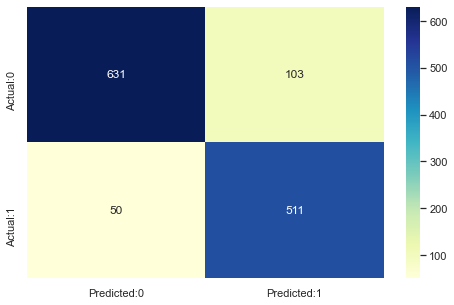

In [87]:
cm=confusion_matrix(y_test,svm_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [88]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
print(cm)

[[631 103]
 [ 50 511]]


In [89]:
TP, FN, TN, FP

(511, 50, 631, 103)

In [90]:
# Recall and sensitivity are the same

recall = TP/(TP + FN)
recall

0.910873440285205

In [91]:
sensitivity = TP/(TP + FN)
sensitivity

0.910873440285205

In [93]:
precision = TP / (TP + FP)
precision

0.8322475570032574

In [95]:
specificity = TN / (TN + FP)
specificity

0.8596730245231607

In [ ]:
print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',
'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',
'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',
'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',
'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',
'Negative Predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',
'Positive Likelihood Ratio = sensitivity/(1-specificity) = ',sensitivity/(1-specificity),'\n',
'Negative Likelihood Ratio = (1-sensitivity)/specificity = ',(1-sensitivity)/specificity)

The winning model SVM needs to be further analyzed.  Let’s breaks it down:
Recall/Sensitivity is 94.25%
Precision is 83.86%
Specibility is 86.54%

Since I am predicting heart disease, the higher recall score of 94.25% is the most important value.  It is good because the false negative is more critical and we don’t want to miss any patients who have heart disease.  

In [96]:
print(classification_report(y_test,svm_predict))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       734
           1       0.83      0.91      0.87       561

    accuracy                           0.88      1295
   macro avg       0.88      0.89      0.88      1295
weighted avg       0.89      0.88      0.88      1295



In [97]:
svm_f1 = f1_score(y_test, svm_predict)
print(f'The f1 score for SVM is {round(svm_f1*100,2)}%')

The f1 score for SVM is 86.98%


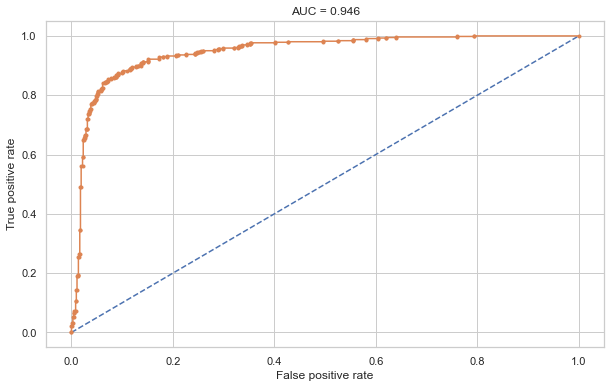

In [98]:
# ROC curve and AUC 
probs = svm_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
svm_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(svm_auc,3)}")
plt.show()

Models Comparison

In [99]:
comparison = pd.DataFrame({
    "Logistic regression":{'Accuracy':log_accuracy, 'AUC':log_auc, 'F1 score':logistic_f1},
    "K-nearest neighbours":{'Accuracy':knn_accuracy, 'AUC':knn_auc, 'F1 score':knn_f1},
    "Decision trees":{'Accuracy':tree_accuracy, 'AUC':tree_auc, 'F1 score':tree_f1},
    "Support vector machine":{'Accuracy':svm_accuracy, 'AUC':svm_auc, 'F1 score':svm_f1}
}).T

In [100]:
comparison

,Accuracy,AUC,F1 score
Logistic regression,0.660232,0.712005,0.633943
K-nearest neighbours,0.844788,0.858668,0.843091
Decision trees,0.757529,0.762576,0.740924
Support vector machine,0.881853,0.945956,0.869787


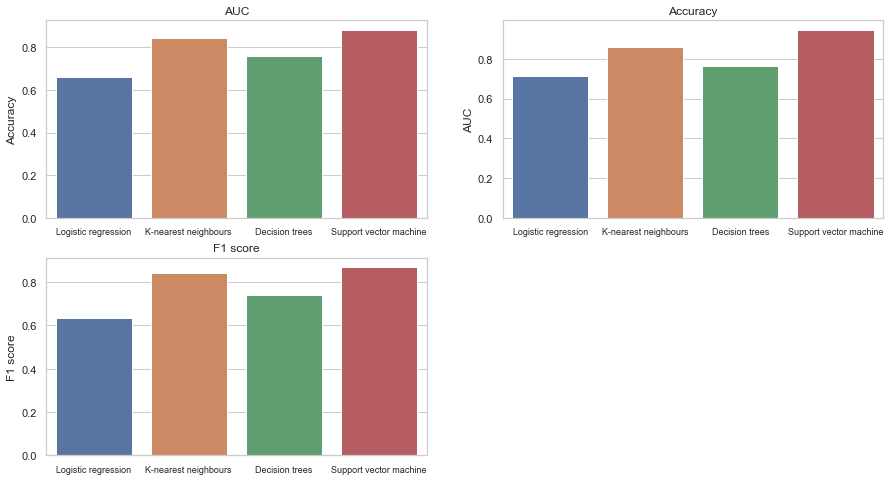

In [101]:
fig = plt.gcf()
fig.set_size_inches(15, 8)
titles = ['AUC','Accuracy','F1 score']
for title,label in enumerate(comparison.columns):
    plt.subplot(2,2,title+1)
    sns.barplot(x=comparison.index, y = comparison[label], data=comparison)
    plt.xticks(fontsize=9)
    plt.title(titles[title])
plt.show()

After implementing four classification models and comparing their accuracy, I can conclude that SVM is the appropriate model to be used for this dataset because the scores on SVM is highest on all those models 